# G-Research Crypto Forecasting Kaggle Competition

Let us use linear regression for predicting price returns across a bundle of major cryptocurrencies using the time-series of historical prices as training data.

In [1]:
import sys
sys.path.insert(0, '/kaggle/input/g-research-crypto-forecasting')
import gresearch_crypto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

## Getting the Training Data

Let us import the training data.

In [2]:
train_df = pd.read_csv('../input/g-research-crypto-forecasting/train.csv', low_memory=False, 
                       dtype={'Asset_ID': 'int8', 'Count': 'int32', 'row_id': 'int32', 'Count': 'int32', 
                              'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 
                              'Volume': 'float64', 'VWAP': 'float64'
                             }
                      )
train_df.set_index('timestamp', inplace=True)
train_df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,2,40,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1514764860,0,5,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
1514764860,1,229,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
1514764860,5,32,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
1514764860,7,5,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


Let's look at which crypto assets we are dealing with.

In [3]:
asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv', 
                            index_col='Asset_ID')
asset_details.sort_index(inplace=True)
asset_details

,Weight,Asset_Name
Asset_ID,,
0,4.304065,Binance Coin
1,6.779922,Bitcoin
2,2.397895,Bitcoin Cash
3,4.406719,Cardano
4,3.555348,Dogecoin
5,1.386294,EOS.IO
6,5.894403,Ethereum
7,2.079442,Ethereum Classic
8,1.098612,IOTA


We can see that some of the `VWAP` and `Target` values are Nan.

In [4]:
train_df.isna().sum()

Asset_ID         0
Count            0
Open             0
High             0
Low              0
Close            0
Volume           0
VWAP             9
Target      750338
dtype: int64

We can also see that not all of the cryptocurrencies existed at the same time (ie some of the `Asset_ID` values which should be in `asset_details.index` = [0, 1, 2, ..., 13] are missing.

In [5]:
train_df.loc[train_df.index[0]]

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,2,40,2376.5800,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1514764860,0,5,8.5300,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
1514764860,1,229,13835.1940,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
1514764860,5,32,7.6596,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
1514764860,7,5,25.9200,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
1514764860,6,173,738.3025,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
1514764860,9,167,225.3300,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
1514764860,11,7,329.0900,329.8800,329.0900,329.460000,6.635710,329.454118,NaN


Let us find out the earliest timestamp for which all of our cryptocurrencies existed with numerical `Target` values.

In [6]:
# for i in train_df.index.unique():
#     if train_df.loc[i, 'Asset_ID'].sum() == sum(asset_details.index):
#         print(i)
#         first_idx = i
#         break

# this cell takes a while to run so I will just put the answer here
first_idx = 1555080120

We can see that starting from this point leads to losing the first just under 30% of our training data.

In [7]:
(1-len(train_df.loc[first_idx:])/len(train_df))*100

29.992569978073846

Let us get the last index of our data.

In [8]:
last_idx = train_df.index[-1]
last_idx

1632182400

## Feature Selection

Let us use our Binance Coin data to look at which features most correlate to the `Target` data. We can pad the data to get every minute and forward fill because according to the random walk hypothesis our best estimate for a rabdom walk time series is the previous value. 

In [9]:
bnb = train_df[train_df["Asset_ID"]==0].reindex(range(first_idx, 
                                                      last_idx+60, 60),method='pad').fillna(method='ffill')
bnb.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1555080120,0,12,17.8425,17.8500,17.8351,17.8500,124.38,17.844331,0.000784
1555080180,0,8,17.8498,17.8500,17.8497,17.8498,720.49,17.849790,0.002931
1555080240,0,36,17.8499,17.8499,17.8082,17.8082,1083.42,17.839889,0.003159
1555080300,0,19,17.8240,17.8240,17.8168,17.8209,519.36,17.819413,0.003851
1555080360,0,12,17.8210,17.8262,17.8114,17.8114,384.67,17.821414,0.003932


Let us see which features of the data best correlate with `Target`.

In [10]:
bnb.corr()['Target'].iloc[1:-1].sort_values(ascending=False)

Count     0.015525
Volume    0.014806
Open     -0.000572
Low      -0.000578
VWAP     -0.000580
Close    -0.000581
High     -0.000582
Name: Target, dtype: float64

It appears that Count and Volume have the greatest absolute value of their correlation, albeit a small one < 0.016. Let's look for the partial autocorrelation for these features. We can see that these values are  dependent on their ~ 10 previous values.

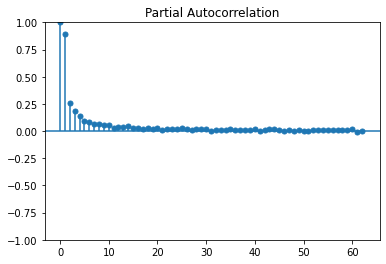

In [11]:
plot_pacf(bnb['Count'], method='ywm');

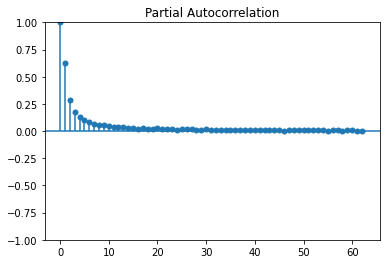

In [12]:
plot_pacf(bnb['Volume'], method='ywm');

We can also use principal component analysis (PCA) to find features that correlate well with the overall trend of the data. We can see that almost 70% of the variance of the data can be explained by the first principal axis.

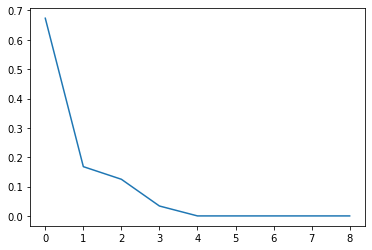

In [13]:
X_bnb_pca = bnb.to_numpy()

scaler = StandardScaler()
X_bnb_pca = scaler.fit_transform(X_bnb_pca)

model_bnb_pca = PCA()
Z_bnb_pca = model_bnb_pca.fit_transform(X_bnb_pca)

plt.plot(model_bnb_pca.explained_variance_ratio_);

We can see that the most of the variance in the data can be explained by `High`.

In [14]:
Z_bnb_pca_df = pd.DataFrame(index=bnb.index)
Z_bnb_pca_df['PC1'] = Z_bnb_pca[:,0]
joined = bnb.join(Z_bnb_pca_df)
joined.corr()['PC1'].iloc[1:-1].sort_values(ascending=False)

High      0.992978
Open      0.992851
VWAP      0.992839
Close     0.992839
Low       0.992695
Count     0.663577
Volume    0.139117
Target    0.002163
Name: PC1, dtype: float64

We can see that the `High` price is based mostly on its previous value.

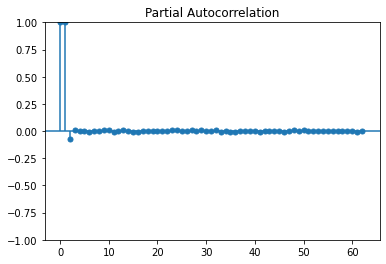

In [15]:
plot_pacf(bnb['High'], method='ywm');

Based on these results, let us use `Count`, `High`, and `Volume` as the features for our linear regression model.

## Cleaning and Training the Data

Let us make a list of `DataFrame`s for each asset.

In [16]:
train_df_list = []
for asset_id in range(len(asset_details)):
    train_df_list.append(train_df[train_df["Asset_ID"]==asset_id].reindex(range(first_idx, 
                                                    last_idx+60, 60),method='pad').fillna(method='ffill').fillna(method='bfill'))

In [17]:
train_df_list[0].head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1555080120,0,12,17.8425,17.8500,17.8351,17.8500,124.38,17.844331,0.000784
1555080180,0,8,17.8498,17.8500,17.8497,17.8498,720.49,17.849790,0.002931
1555080240,0,36,17.8499,17.8499,17.8082,17.8082,1083.42,17.839889,0.003159
1555080300,0,19,17.8240,17.8240,17.8168,17.8209,519.36,17.819413,0.003851
1555080360,0,12,17.8210,17.8262,17.8114,17.8114,384.67,17.821414,0.003932


In [18]:
train_df_list[0].isna().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

Let us now change that list to reflect only the features that we want for our linear regression model.

In [19]:
X_list = []
for i in range(len(train_df_list)):
    X_list.append(train_df_list[i][['Count', 'High', 'Volume']])

In [20]:
X_list[0].head()

,Count,High,Volume
timestamp,,,
1555080120,12,17.8500,124.38
1555080180,8,17.8500,720.49
1555080240,36,17.8499,1083.42
1555080300,19,17.8240,519.36
1555080360,12,17.8262,384.67


We can make our list for the target values we will use to train our model.

In [21]:
y_list = []
for i in range(len(train_df_list)):
    y_list.append(train_df_list[i]['Target'])

Let us now set the training and testing window. We have just under 2.5 years of data here, so let's make the test set the last month. We will create our train and test sets and then scale them before using them to train and test our model.

In [22]:
Ntest = 43830 # 1 month in minutes

In [23]:
X_list_train = []
for i in range(len(train_df_list)):
    X_list_train.append(X_list[i].iloc[:-Ntest].to_numpy())

In [24]:
y_list_train = []
for i in range(len(train_df_list)):
    y_list_train.append(y_list[i].iloc[:-Ntest].to_numpy())

In [25]:
X_list_test = []
for i in range(len(train_df_list)):
    X_list_test.append(X_list[i].iloc[-Ntest:].to_numpy())

In [26]:
y_list_test = []
for i in range(len(train_df_list)):
    y_list_test.append(y_list[i].iloc[-Ntest:].to_numpy())

Now let us scale the data.

In [27]:
X_list_train_scaled = []
for i in range(len(train_df_list)):
    X_list_train_scaled.append(scaler.fit_transform(X_list_train[i]))

In [28]:
X_list_test_scaled = []
for i in range(len(train_df_list)):
    X_list_test_scaled.append(scaler.fit_transform(X_list_test[i]))

## Linear Regression Model

Let us now fit a linear regression model to the data.

In [29]:
lr = LinearRegression()

In [30]:
model_list = []
y_pred_lr_list = []
for i in range(len(train_df_list)):
    model_list.append(LinearRegression())
    model_list[i].fit(X_list_train_scaled[i], y_list_train[i])
    y_pred_lr_list.append(model_list[i].predict(X_list_test_scaled[i]))

Let us check the performance of our model against the test data.

In [31]:
for i in range(len(train_df_list)):
    print('Test score for LR: %s' % asset_details.loc[i, 'Asset_Name'], f"{np.corrcoef(y_pred_lr_list[i], y_list_test[i])[0,1]:.2f}")

Test score for LR: Binance Coin 0.05
Test score for LR: Bitcoin 0.04
Test score for LR: Bitcoin Cash -0.04
Test score for LR: Cardano 0.09
Test score for LR: Dogecoin 0.08
Test score for LR: EOS.IO -0.03
Test score for LR: Ethereum 0.02
Test score for LR: Ethereum Classic 0.04
Test score for LR: IOTA 0.02
Test score for LR: Litecoin -0.03
Test score for LR: Maker 0.01
Test score for LR: Monero 0.04
Test score for LR: Stellar 0.00
Test score for LR: TRON 0.03


## Submission

In [32]:
env = gresearch_crypto.make_env()

In [33]:
iter_test = env.iter_test()

In [34]:
submission = pd.DataFrame(columns=['group_num', 'row_id', 'Target'])
group_num = 0
for (test_df, sample_prediction_df) in iter_test:
    test_df.fillna(0).set_index('row_id')
    for asset_id in test_df['Asset_ID']:
        X_tmp = test_df[test_df['Asset_ID'] == asset_id][['Count', 'High', 'Volume']].copy()
        sample_prediction_df.loc[X_tmp.index, 'Target'] = model_list[asset_id].predict(X_tmp.to_numpy())
    tmp = sample_prediction_df.copy()
    tmp['group_num'] = group_num
    group_num+=1
    submission = submission.append(tmp)
    env.predict(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [35]:
submission.head()

,group_num,row_id,Target
0,0,0,53.568761
1,0,1,0.071465
2,0,2,0.064669
3,0,3,0.419349
4,0,4,202.288064


In [36]:
submission.to_csv('submission.csv', index=False)